In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from gekko import GEKKO
from IPython.display import display
pd.set_option('display.max_columns', None)    # Show all columns

In [1]:
class Leaf:
    def __init__(self, Parameters=None):
        """ Initializes the class with user-defined parameters, supplemented by default values.
        Parameters: Dictionary containing user-defined parameter values 
        default_Parameters: Dictionary containing default parameter values.

        Parameter description:
        vcmax25 = Maximum rubisco photosynthetic capacity
        vpmax25 = Maximum PEP photosynthetic capacity
        jmax25 = Maximum electron transport rate
        Vpr25 = Maximum PEP regeneration rate
        sco25 = Rubisco specificity
        Ko25 = Michaelis-Menten constant of Rubisco for O2
        Kc25 = Michaelis-Menten constant of Rubisco for CO2
        Kp25 = Michaelis-Menten constant of PEP carboxylase for CO2
        gbs = Bundle sheath conductance
        alpha = Fraction of O2 evolving in bundle sheath from rubisco carboxylation
        theta = Curvature parameter for AQ curve
        x = Fraction of electron transport rate partitioned to PEP carboxylation
        rd = Ratio of respiration rate to rubisco carboxylation rate
        go = Residual stomatal condutance
        g1 = Sensitivity paramter for the stomatal condutance
        leafDim = Leaf dimension
        cForced = Coefficient for forced conductance
        cFree = Coefficient for free conductance
        s = Ratio of stomata density on the adaxial side to that of abaxial side of the leaf        
        """
        
        # Default parameter values
        default_Parameters = { "vcmax25":50.0, "vpmax25":110.0, "jmax25":350.0, "vpr25":80.0, "sco25":2590.0, \
                              "Ko25":450.0, "Kc25":650.0, "Kp25":80.0, "gbs":0.003, "alpha":0.0, "theta":0.7, \
                              "x":0.4, "rd25":0.05, "go":0.08, "g1":3.0, "leafDim":0.08,"cForced":0.004322, \
                              "cFree":0.001631, "s":0.71, "switch":1}        
        # Merge user-provided parameters with defaults
        Leafparams = default_Parameters.copy()
        if Parameters:
            Leafparams.update(Parameters)

        self.Leafparams = Leafparams
        self.vcmax25 = Leafparams['vcmax25']
        self.vpmax25 = Leafparams['vpmax25']
        self.jmax25 = Leafparams['jmax25']
        self.vpr25 = Leafparams['vpr25']
        self.sco25 = Leafparams['sco25']
        self.Ko25 = Leafparams['Ko25'] 
        self.Kc25 = Leafparams['Kc25'] 
        self.Kp25 = Leafparams['Kp25']  
        self.gbs = Leafparams['gbs'] 
        self.alpha = Leafparams['alpha']
        self.theta = Leafparams['theta'] 
        self.x = Leafparams['x'] 
        self.rd25 = Leafparams['rd25']
        self.go = Leafparams['go'] 
        self.g1 = Leafparams['g1'] 
        self.leafDim = Leafparams['leafDim'] 
        self.cForced = Leafparams['cForced'] 
        self.cFree = Leafparams['cFree'] 
        self.s = Leafparams['s'] 
        self.switch = Leafparams['switch'] 

    def __str__(self):
        """ Returns a string representation of the class with all parameters."""
        param_str = "; ".join([f"{key}: {value}" for key, value in self.Leafparams.items()])
        return f"Leaf Parameters:\n{param_str}"
 
    def initialize(self,Weather):
        self.__flag = 0.0
        self.__cbs = Weather['ca'] * 10.0
        self.__obs = Weather['O2']
        self.__ci = Weather['ca'] * 0.7
        self.__cb = Weather['ca'] * 0.8
        self.__gs = 0.1
        self.__tLeaf = Weather['tAir']
        self.__ei = 1.2 * (0.611 * np.exp(17.502 * Weather['tAir'] / (240.97 + Weather['tAir']))) * 1000
        self.__eb = self.__ei  
        self.__gbForced = 1.0
        self.__gbFree = 1.0
        self.__gb = 5.0
        self.__g = 0.4
        self.__Ko = 450.0
        self.__Kc = 80.0
        self.__Kp = 650.0
        self.__gammaStar = 0.000193
        self.__GammaStar = 0.143
        self.__Gamma = 1.0
        self.__Gamma_C = 20.0
        self.__Terror = 0.0
        self.__Aerror = 0.0
        self.__Cierror = 0.0
        self.__Gserror = 0.0

        # Initialize LeafMassFlux
        self.__rd = self.rd25 * self.vcmax25
        self.__rbs = self.__rd / 2
        self.__rm = self.__rd / 2
        self.__J = self.jmax25
        self.__aNet = 0.1 * Weather['ca']
        self.__aGross = 2.0
        self.__acCO2 = 0.0
        self.__acLight = 0.0
        self.__apCO2 = 0.0
        self.__apLight = 0.0
        self.__L = 0.5
        self.__vp = 2.0
        self.__vc = 2.0
        self.__vpLight = 2.0
        self.__vpCO2 = 2.0
        self.__vcLight = 2.0
        self.__vcCO2 = 2.0
        self.__vpmax = self.vpmax25
        self.__vcmax = self.vcmax25
        self.__jmax = self.jmax25
        self.__transpiration = 0.0

        # Initialize LeafEnergyFlux
        self.__H = 0.0  # Sensible heat flux [W m^-2]
        self.__LE = 0.0  # Latent heat flux [W m^-2]
        self.__emission = 0.0 # Long wave radiation flux emitted [W m^-2]
        self.__radiation = 0  # Net radiation flux [W m^-2]
        self.__residual = 100.0 # Error radiation flux [W m^-2]

    def TemperatureResponse(self):
        # Temperature response of photosynthesis parameters
        R = 8.314E-3
        self.__ei = (0.611 * np.exp(17.502 * self.__tLeaf / (240.97 + self.__tLeaf))) * 1000
        self.__Ko = self.Ko25 * (1.2 ** ((self.__tLeaf - 25.0) / 10.0))  # Michaelis constant of Rubisco for O2 [m bar]
        self.__Kc = self.Kc25 * (2.1 ** ((self.__tLeaf - 25.0) / 10.0))  # Michaelis constant of Rubisco for CO2 [u bar]
        self.__Kp = self.Kp25 * (2.1 ** ((self.__tLeaf - 25.0) / 10.0))   # Michaelis constant of PEP carboxylase for CO2 [u bar]
        
        leafTemperatureKelvin = self.__tLeaf + 273.15  # Leaf temperature in Kelvin
        
        self.__jmax = self.jmax25 * np.exp(
            77900.0 * (leafTemperatureKelvin - 298.15) / (298.15 * R * 1000.0 * leafTemperatureKelvin)
        ) * (1.0 + np.exp((298.15 * 627.0 - 191929.0) / (298.15 * R * 1000.0))) / (
            1.0 + np.exp((leafTemperatureKelvin * 627.0 - 191929.0) / (leafTemperatureKelvin * R * 1000.0))
        )  # Max electron transport rate [u moles m^-2 s^-1]
        
        self.__vcmax = self.vcmax25 * np.exp(
            67294.0 * (leafTemperatureKelvin - 298.15) / (298.15 * R * 1000.0 * leafTemperatureKelvin)
        ) * (1.0 + np.exp((298.15 * 472.0 - 144568.0) / (298.15 * R * 1000.0))) / (
            1.0 + np.exp((leafTemperatureKelvin * 472.0 - 144568.0) / (leafTemperatureKelvin * R * 1000.0))
        )  # Max RuBP saturated carboxylation [u moles m^-2 s^-1]
        
        self.__vpmax = self.vpmax25 * np.exp(
            70373.0 * (leafTemperatureKelvin - 298.15) / (298.15 * R * 1000.0 * leafTemperatureKelvin)
        ) * (1.0 + np.exp((298.15 * 376.0 - 117910.0) / (298.15 * R * 1000.0))) / (
            1.0 + np.exp((leafTemperatureKelvin * 376.0 - 117910.0) / (leafTemperatureKelvin * R * 1000.0))
        )  # Max PEP carboxylation rate [u moles m^-2 s^-1]
        
        Sco = self.sco25 * 1E-3 * np.exp(
            -55900.0 * (leafTemperatureKelvin - 298.15) / (298.15 * R * 1000.0 * leafTemperatureKelvin)
        )
        self.__gammaStar = 1 / (2 * Sco)  # Half of reciprocal of Rubisco specificity [-]
        
        self.__rd = self.rd25 * self.__vcmax
        self.__rm = 0.5 * self.__rd
        self.__rbs = 0.5 * self.__rd

    def BoundaryLayer(self,Weather):
        # Boundary layer Conductance Module
        temperatureKelvin = Weather['tAir'] + 273.15  # Air temperature [Kelvin]
        convert_gb = Weather['pressure'] / (8.309 * temperatureKelvin)  # Conversion of boundary layer conductance [m s^-1] to [moles m^-2 s^-1]
        leafTemperatureKelvin = self.__tLeaf + 273.15  # Leaf temperature [Kelvin]
                
        # Forced convection conductance
        self.__gbForced = self.cForced * temperatureKelvin**0.56 * (
            ((temperatureKelvin + 120.0) * (Weather['wind'] / self.leafDim / Weather['pressure']))**0.5
        )  # Boundary layer forced conductance [m s^-1]
        
        # Free convection conductance
        TDifference = (leafTemperatureKelvin / (1.0 - 0.378 * self.__eb / Weather['pressure'])) - (
            temperatureKelvin / (1.0 - 0.378 * Weather['ea'] / Weather['pressure'])
        )  # Virtual temperature difference [Kelvin]
        self.__gbFree = self.cFree * leafTemperatureKelvin**0.56 * (
            ((leafTemperatureKelvin + 120.0) / Weather['pressure'])**0.5 * (abs(TDifference) / self.leafDim)**0.25
        )  # Boundary layer free conductance [m s^-1]
        
        # Maximum of two conductances
        self.__gb = max(self.__gbFree, self.__gbForced)  # Boundary layer conductance for vapour [m s^-1]
        
        # Compute leaf boundary layer conductance for vapour
        self.__gb = self.__gb * convert_gb  # Boundary layer conductance for vapour [mol m^-2 s^-1]

    def CO2Transport(self,Weather):
        self.__Mb = 0.5*(1+self.s)**2/(1+self.s**2)
        convert_PAR = 4.57 
        
        # Total leaf vapour conductance [mol m^-2 sec^-1]
        self.__g = self.__gs*self.__gb*self.__Mb/(self.__gs + self.__gb*self.__Mb)
        
        # Vapour Pressure at leaf for boundary layer conductance [Pa]
        self.__eb = (self.__gs*self.__ei + self.__gb*self.__Mb*Weather['ea']) / \
            (self.__gs  + self.__gb*self.__Mb)
        
        # Photosynthesis module - Preliminary Calculations for suitable Initial Calculations
        
        # Electron Transport rate
        PhiPS2 = 0.352 + 0.022 * self.__tLeaf - 3.4 * (self.__tLeaf)**2.0 / 10000.0
        ThetaPS2 = self.theta
        I = Weather['PAR'] * convert_PAR * PhiPS2 / 2
        self.__J = (I + self.__jmax - ((I + self.__jmax)**2.0 - 4.0 * ThetaPS2 * I * self.__jmax)**0.5) /\
                    (2 * ThetaPS2)
        
        # Anet Calculation
        self.__vcLight = (self.__cbs*(1 - self.x)*self.__J) / (3*self.__cbs + 7*self.__GammaStar)
        self.__vcCO2 = (self.__cbs*self.__vcmax) / (self.__cbs + self.__Kc*(1 + self.__obs/self.__Ko))
        self.__vc = min(self.__vcCO2, self.__vcLight)
        
        # Oxygen Calculation
        self.__obs = self.alpha * self.__aNet / (0.047 * self.gbs) + Weather['O2']  # O2 conc. at bundle sheath [u moles mole^-1]
        self.__vpLight = self.x * self.__J / 2
        self.__vpCO2 = min(self.__ci * self.__vpmax / (self.__ci + self.__Kp), 100)
        self.__vp = min(self.__vpLight, self.__vpCO2)
        
        if self.__vcCO2 < self.__vcLight:
            self.__a1 = self.__vcmax
            self.__b1 = self.__Kc * (1 + self.__obs / self.__Ko)
        else:
            self.__a1 = (1 - self.x) * self.__J / 3
            self.__b1 = 7 * self.__GammaStar / 3
        
        # Sublimitation calculations for photosynthesis
        self.__acCO2 = (1.0 - self.__gammaStar * self.__obs / self.__cbs) * self.__vcCO2 - self.__rd
        self.__acLight = (1.0 - self.__gammaStar * self.__obs / self.__cbs) * self.__vcLight - self.__rd
        self.__apCO2 = (1.0 - self.__gammaStar * self.__obs / self.__cbs) * self.__vpCO2 - self.__rd
        self.__apLight = (1.0 - self.__gammaStar * self.__obs / self.__cbs) * self.__vpLight - self.__rd
        
        # Compensation point calculation
        self.__GammaStar = self.__gammaStar * self.__obs
        self.__Gamma_C = (self.__GammaStar + self.__Kc * (1 + self.__obs / self.__Ko) * self.__rd / self.__vcmax) / \
        (1 - self.__rd / self.__vcmax)  # Gamma for enzyme limited
        if self.__Gamma_C < 0:
            self.__Gamma_C = 0
        
        GammaQuadratic = [ (self.gbs),
            (self.gbs * (self.__Kp - self.__Gamma_C) + self.__vpmax - self.__rm),
            -(self.__Gamma_C * self.__Kp * self.gbs + self.__rm * self.__Kp) ]
        
        try:
            Root = np.roots(GammaQuadratic)
            self.__Gamma = max(Root)
            if self.__Gamma < 0:
                self.__Gamma = 2
                print('I am assuming the compensation point as 2')
        except:
            self.__Gamma = 2

    def CO2Iteration(self):        
        SX = np.array([10, 1000, 100, 0.1, 100]).T  # Scaling for variables
        SFx = np.array([10, 1000, 100, 0.1, 100]).T # Scaling for functions
        
        # Variable Vector
        X = np.array([self.__aNet, self.__cbs, self.__ci, self.__gs, self.__cb])/SX

        f0 = lambda X, SX: (X[0] * SX[0]) - (1 - self.__GammaStar / (X[1] * SX[1])) * \
                           ((X[1] * SX[1]) * self.__a1 / ((X[1] * SX[1]) + self.__b1)) + self.__rd
        
        f1 = lambda X, SX: (X[1] * SX[1]) - (X[2] * SX[2]) - (self.__vp - (X[0] * SX[0]) - self.__rm) / self.gbs
        
        f2 = lambda X, SX: (X[2] * SX[2]) - (X[4] * SX[4]) + 1.6 * (X[0] * SX[0]) / (X[3] * SX[3])
        
        f3 = lambda X, SX: (X[3] * SX[3]) - self.go - self.g1 * (X[0] * SX[0]) * \
                           self.__eb / self.__ei / ((X[4] * SX[4]) - self.__Gamma)
        
        f4 = lambda X, SX: (X[4] * SX[4]) - Weather['ca'] + 1.37 * (X[0] * SX[0]) / (self.__gb * self.__Mb)
        
        # Function vector
        F = lambda X, SX: np.array([f0(X, SX), f1(X, SX), f2(X, SX), f3(X, SX), f4(X, SX)]) / SFx       

        # Stomatal conductance checks
        if self.__gs <= self.go:
            self.__gs = self.go
            df3_dX0 = 0
            df3_dX4 = 0
        else:
            df3_dX0 = -self.g1 * (self.__eb / self.__ei) * (SX[0] / (X[4] * SX[4] - self.__Gamma))
            df3_dX4 = self.g1 * (self.__eb / self.__ei) * (SX[0] * X[0] * SX[4] / (X[4] * SX[4] - self.__Gamma)**2)

        # Derivatives
        df0_dX0 = SX[0]
        df0_dX1 = -(SX[1] * self.__a1 * (self.__GammaStar + self.__b1) / (self.__b1 + X[1] * SX[1])**2)
        df0_dX2 = 0
        df0_dX3 = 0
        df0_dX4 = 0
        
        df1_dX0 = SX[0] / self.gbs
        df1_dX1 = SX[1]
        df1_dX2 = -SX[2]
        df1_dX3 = 0
        df1_dX4 = 0
        
        df2_dX0 = 1.6 * SX[0] / (SX[3] * X[3])
        df2_dX1 = 0
        df2_dX2 = SX[2]
        df2_dX3 = -1.6 * SX[0] * X[0] / (SX[3] * X[3]**2)
        df2_dX4 = -SX[4]
        
        df3_dX1 = 0
        df3_dX2 = 0
        df3_dX3 = SX[3]
        
        df4_dX0 = 1.37 * SX[0] / (self.__gb * self.__Mb)
        df4_dX1 = 0
        df4_dX2 = 0
        df4_dX3 = 0
        df4_dX4 = SX[4]
        
        # Jacobian Matrix
        dF = (np.array([
            [df0_dX0, df0_dX1, df0_dX2, df0_dX3, df0_dX4],
            [df1_dX0, df1_dX1, df1_dX2, df1_dX3, df1_dX4],
            [df2_dX0, df2_dX1, df2_dX2, df2_dX3, df2_dX4],
            [df3_dX0, df3_dX1, df3_dX2, df3_dX3, df3_dX4],
            [df4_dX0, df4_dX1, df4_dX2, df4_dX3, df4_dX4],
        ]).T/SFx).T
    
        # Proceeding with the iterations
        try:
            if np.linalg.matrix_rank(dF) == dF.shape[0]:
                X1 = X - np.linalg.solve(dF, F(X, SX))
            else:
                print("Singular matrix problem")
                X1 = X - np.linalg.pinv(dF) @ F(X, SX)
            if np.linalg.norm(F(X1, SX)) > np.linalg.norm(F(X, SX)):  # sum(F(X1)^2) > sum(F(X)^2)
                self.__relax = 0.5
                X1 = X - self.__relax * np.linalg.solve(dF, F(X, SX))
        except:
            print("Something's wrong")
            X1 = 0.5*(X+X1)
        
        if self.__CO2iteration > 50:
            self.__relax = max(0.1, self.__relax - 0.01)
        
        # Successive under relaxation
        X1 = X1 * self.__relax + X * (1 - self.__relax)  # Applying relaxation
        self.__aNet = X1[0] * SX[0]
        self.__cbs = X1[1] * SX[1]
        self.__ci = X1[2] * SX[2]
        self.__gs = X1[3] * SX[3]
        self.__cb = X1[4] * SX[4]
        self.__L = self.gbs*(self.__cbs-self.__ci);
        self.__aGross = self.__aNet + self.__rd;

    def EnergyBalanceModule(self,Weather):
        # Constants (placeholders for the actual constants, adjust accordingly)
        Boltzman = 5.67e-8  # Stefan-Boltzmann constant [W m^-2 K^-4]
        Cp = 29.3  # Specific heat capacity of air [J kg^-1 K^-1]
        Hfactor = 1  # Placeholder for Hfactor
        LEfactor = 1  # Placeholder for LEfactor
        LWfactor = 2  # Placeholder for LWfactor
        epsilonLeaf = 0.94  # Placeholder for emissivity of leaf        

        m2 = GEKKO(remote=False)

        # Function to calculate Latent Heat (callLv)
        callLv = lambda temperature: (2500 - 2.36 * temperature) * 18    
        # Function to calculate Saturation Vapour Pressure (callEs)
        callEs = lambda temperature: (0.611 * m2.exp(17.502 * temperature / (240.97 + temperature))) * 1000  # Clausius–Clapeyron relation    
        callEs1 = lambda temperature: (0.611 * np.exp(17.502 * temperature / (240.97 + temperature))) * 1000  # Clausius–Clapeyron relation
        # Sensible heat flux (callSensibleHeat)
        callSensibleHeat = lambda gbh, temperature, tAir: Hfactor * Cp * gbh * (temperature - tAir)    
        # Latent heat flux (callLatentHeat)
        callLatentHeat = lambda gv, temperature, pressure, ea: LEfactor * callLv(temperature) * gv / pressure * (callEs(temperature) - ea)
        callLatentHeat1 = lambda gv, temperature, pressure, ea: LEfactor * callLv(temperature) * gv / pressure * (callEs1(temperature) - ea)
        # Long wave radiation flux (callEmission)
        callEmission = lambda temperature: LWfactor * epsilonLeaf * Boltzman * (273.15 + temperature) ** 4

        X = m2.Var(self.__tLeaf)
        X.LOWER = 2  # Set lower bound for x1
        X.UPPER = 60  # Set upper bound for x1

        f6 = lambda X: ( Weather['PAR'] + Weather['NIR'] + Weather['long'] -
            0.506*self.__aNet - callSensibleHeat(self.__gb*0.924, X, Weather['tAir']) -
            callLatentHeat(self.__g, X, Weather['pressure'], Weather['ea']) - callEmission(X))
        f6_1 = lambda X: ( Weather['PAR'] + Weather['NIR'] + Weather['long'] -
            0.506*self.__aNet - callSensibleHeat(self.__gb*0.924, X, Weather['tAir']) -
            callLatentHeat1(self.__g, X, Weather['pressure'], Weather['ea']) - callEmission(X))

        F = m2.Intermediate(f6(X)**2)

        if self.switch == 1:
            objective = m2.Minimize(F)        
            m2.solve(disp=False)        
            T_opt = X.value[0]            
        else:
            T_opt = Weather['tAir']
            
        self.__tLeaf = T_opt
            
                
        self.__radiation = Weather['PAR'] + Weather['NIR'] + Weather['long']  # Net radiation flux [W m^-2]
        self.__H = callSensibleHeat(self.__gb * 0.924, self.__tLeaf, Weather['tAir'])  # Sensible heat flux [W m^-2]
        self.__LE = callLatentHeat1(self.__g, self.__tLeaf, Weather['pressure'], Weather['ea'])  # Latent heat flux [W m^-2]
        self.__emission = callEmission(self.__tLeaf)  # Long wave radiation flux emitted [W m^-2]
        self.__residual = f6_1(self.__tLeaf) # Net radiation residual [W m^-2]
        self.__transpiration = self.__LE / callLv(self.__tLeaf) * 1E6  # Leaf transpiration in µmoles m^-2 s^-1   

    def Solve(self,Weather):
        self.__Terror = 10
        Tempiteration = 0
        while self.__Terror > 0.1 and Tempiteration < 20:
            error = 10
            T_old = self.__tLeaf
            self.TemperatureResponse()
            self.BoundaryLayer(Weather)
            
            self.__relax = 0.5
            self.__CO2iteration = 0
            while error > 0.1 and self.__CO2iteration < 100:
                old = np.array([self.__aNet,self.__ci,self.__gs])
                self.CO2Transport(Weather)
                self.CO2Iteration()
                new = np.array([self.__aNet,self.__ci,self.__gs])
                self.__Aerror = new[0] - old[0]
                self.__Cierror = new[1] - old[1]
                self.__Gserror = new[2] - old[2]
                error = sum([(x-y)**2 for x,y in zip(old,new)])
                self.__CO2iteration+= 1
                
            self.EnergyBalanceModule(Weather)
            T_new = self.__tLeaf
            self.__Terror = abs(T_new - T_old)
            Tempiteration+= 1
            
    
    @property
    def LeafState(self): return {'flag': [self.__flag], 'cbs': [self.__cbs], 'obs': [self.__obs], 'ci': [self.__ci], \
                                 'cb': [self.__cb], 'gs': [self.__gs], 'tLeaf': [self.__tLeaf], 'ei': [self.__ei], \
                                 'eb': [self.__eb], 'gbForced': [self.__gbForced], 'gbFree': [self.__gbFree], 'gb': [self.__gb],\
                                 'g': [self.__g], 'Ko': [self.__Ko], 'Kc': [self.__Kc], 'Kp': [self.__Kp], \
                                 'gammaStar': [self.__gammaStar], 'GammaStar': [self.__GammaStar], 'Gamma': [self.__Gamma], \
                                 'Gamma_C': [self.__Gamma_C], 'Terror': [self.__Terror], 'Aerror': [self.__Aerror], \
                                 'Cierror': [self.__Cierror], 'Gserror': [self.__Gserror]}
    
    @property
    def LeafMassFlux(self): return {'rd': [self.__rd], 'rbs': [self.__rbs], 'rm': [self.__rm], 'J': [self.__J], \
                                    'aNet': [self.__aNet], 'aGross': [self.__aGross], 'acCO2': [self.__acCO2], \
                                    'acLight': [self.__acLight], 'apCO2': [self.__apCO2], 'apLight': [self.__apLight], \
                                    'L': [self.__L], 'vp': [self.__vp], 'vc': [self.__vc], 'vpLight': [self.__vpLight], \
                                    'vpCO2': [self.__vpCO2], 'vcLight': [self.__vcLight], 'vcCO2': [self.__vcCO2], \
                                    'vpmax': [self.__vpmax], 'vcmax': [self.__vcmax], 'jmax': [self.__jmax], 'transpiration': [self.__transpiration]}
    
    @property
    def LeafEnergyFlux(self): return {'H': [self.__H], 'LE': [self.__LE], 'emission': [self.__emission], \
                                      'radiation': [self.__radiation], 'residual': [self.__residual]}


Text(0, 0.5, '$T_{leaf}$ [$^{o}$C]')

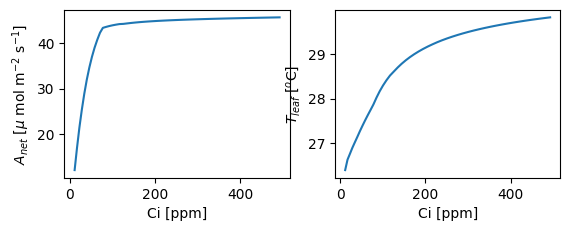

In [11]:
Parameters = {'vcmax25':50,'go':0.08,'g1':3}
C4Leaf = Leaf(Parameters)
Weather = {'ca':420.0, 'O2':210.0, 'tAir':26.6, 'ea':2190.0, 'pressure':98880.0, 'wind':3.9, 'PAR':330.0,'long':800, 'NIR':89}
C4Leaf.initialize(Weather)
Ca = np.arange(40,1000,20)
Anet = []
Ci = []
Tleaf = []
for c in Ca:
    Weather['ca'] = c
    C4Leaf.Solve(Weather)
    Anet.append(C4Leaf.LeafMassFlux['aNet'])
    Ci.append(C4Leaf.LeafState['ci'])
    Tleaf.append(C4Leaf.LeafState['tLeaf'])

plt.subplot(221)
plt.plot(Ci,Anet)
plt.xlabel("Ci [ppm]")
plt.ylabel(r'$A_{net}$ [$\mu$ mol m$^{-2}$ s$^{-1}$]')

plt.subplot(222)
plt.plot(Ci,Tleaf)
plt.xlabel("Ci [ppm]")
plt.ylabel(r'$T_{leaf}$ [$^{o}$C]')

Text(0, 0.5, '$T_{leaf}$ [$^{o}$C]')

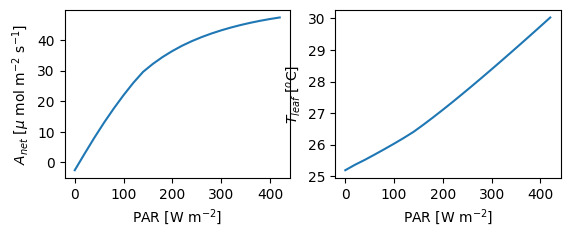

In [10]:
Parameters = {'vcmax25':50,'go':0.08,'g1':3}
C4Leaf = Leaf(Parameters)
Weather = {'ca':420.0, 'O2':210.0, 'tAir':26.6, 'ea':2190.0, 'pressure':98880.0, 'wind':3.9, 'PAR':330.0,'long':800, 'NIR':89}
C4Leaf.initialize(Weather)
PAR = np.arange(0,440,20)
Anet = []
par = []
Tleaf = []
for p in PAR:
    Weather['PAR'] = p
    Weather['NIR'] = 0.23/0.85*p
    C4Leaf.Solve(Weather)
    Anet.append(C4Leaf.LeafMassFlux['aNet'])
    par.append(Weather['PAR'])
    Tleaf.append(C4Leaf.LeafState['tLeaf'])

plt.subplot(221)
plt.plot(par,Anet)
plt.xlabel(r'PAR [W m$^{-2}$]')
plt.ylabel(r'$A_{net}$ [$\mu$ mol m$^{-2}$ s$^{-1}$]')

plt.subplot(222)
plt.plot(par,Tleaf)
plt.xlabel(r'PAR [W m$^{-2}$]')
plt.ylabel(r'$T_{leaf}$ [$^{o}$C]')